<br>
<h1 style = "font-size:40px; font-weight : bold; color : green; text-align: center; border-radius: 10px 15px;">Chest X-Ray: Image Classification with Convolutional Neural Networks </h1>
<br>

---

# Overview

The goal of my project is to use Convolutional Neural Networks on Chest X-Ray images, found in the dataset linked below, to determine which samples are from patients with Pneumonia. 

In medical science, doctors still cannot accurately judge the severity of Pneumonia, even if a patient were to be diagnosed with it. This model I have created is an attempt to quantify that severity. 


Dataset : https://www.kaggle.com/tolgadincer/labeled-chest-xray-images

# <a id='0'>Content</a>
​
- <a href='#1'>Dataset Information</a>  
- <a href='#2'>Importing Packages and Dataset</a>  
- <a href='#3'>Exploring the Data</a>  
- <a href='#4'>Preparing the Data</a>
- <a href='#5'>Custom Model</a>
- <a href='#6'>Performance Metrics</a>

# <a id="1">Dataset Information</a> 

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

# <a id="2">Importing Packages and Dataset</a> 

In [2]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [3]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

**Data Loading**

In [4]:
#Taking unequal number of images from each of the classes for training.

#main_path = "../input/chest-xray-pneumonia/chest_xray/"
main_path = "../input/labeled-chest-xray-images/chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")


train_labels = np.concatenate([np.zeros(len(train_normal)), np.ones(len(train_pneumonia))])
test_labels = np.concatenate([np.zeros(len(test_normal)), np.ones(len(test_pneumonia))])
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]


In [5]:
'''
# Taking equal number of images from each of the classes for training. 
import pandas as pd
import numpy as np
import os
import glob
from sklearn.utils import shuffle

# Set paths
main_path = "../input/labeled-chest-xray-images/chest_xray"
train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")

# Define the number of images to select from each class
NUM_IMAGES_PER_CLASS = 1000  # Adjust this number as needed

# Load image paths
train_normal = glob.glob(train_path + "/NORMAL/*.jpeg")[:NUM_IMAGES_PER_CLASS]
train_pneumonia = glob.glob(train_path + "/PNEUMONIA/*.jpeg")[:NUM_IMAGES_PER_CLASS]

test_normal = glob.glob(test_path + "/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path + "/PNEUMONIA/*.jpeg")

# Combine and shuffle the train dataset
train_images = train_normal + train_pneumonia
train_labels = np.concatenate([np.zeros(len(train_normal)), np.ones(len(train_pneumonia))])
train_labels = to_categorical(train_labels)

train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

# Create DataFrame for training
df_train = pd.DataFrame({'image': train_images, 'class': train_labels.argmax(axis=1)})
df_train['class'] = df_train['class'].map({0: 'Normal', 1: 'Pneumonia'})

# Create DataFrame for testing
test_images = test_normal + test_pneumonia
test_labels = np.concatenate([np.zeros(len(test_normal)), np.ones(len(test_pneumonia))])
test_labels = to_categorical(test_labels)

df_test = pd.DataFrame({'image': test_images, 'class': test_labels.argmax(axis=1)})
df_test['class'] = df_test['class'].map({0: 'Normal', 1: 'Pneumonia'})

# Print class distribution for train and test sets
print("Train Set Class Distribution:")
print(df_train['class'].value_counts())

print("\nTest Set Class Distribution:")
print(df_test['class'].value_counts())
'''

'\n# Taking equal number of images from each of the classes for training. \nimport pandas as pd\nimport numpy as np\nimport os\nimport glob\nfrom sklearn.utils import shuffle\n\n# Set paths\nmain_path = "../input/labeled-chest-xray-images/chest_xray"\ntrain_path = os.path.join(main_path, "train")\ntest_path = os.path.join(main_path, "test")\n\n# Define the number of images to select from each class\nNUM_IMAGES_PER_CLASS = 1000  # Adjust this number as needed\n\n# Load image paths\ntrain_normal = glob.glob(train_path + "/NORMAL/*.jpeg")[:NUM_IMAGES_PER_CLASS]\ntrain_pneumonia = glob.glob(train_path + "/PNEUMONIA/*.jpeg")[:NUM_IMAGES_PER_CLASS]\n\ntest_normal = glob.glob(test_path + "/NORMAL/*.jpeg")\ntest_pneumonia = glob.glob(test_path + "/PNEUMONIA/*.jpeg")\n\n# Combine and shuffle the train dataset\ntrain_images = train_normal + train_pneumonia\ntrain_labels = np.concatenate([np.zeros(len(train_normal)), np.ones(len(train_pneumonia))])\ntrain_labels = to_categorical(train_labels)\n\n

In [6]:
df_train.head()

class  \
0  Normal   
1  Normal   
2  Normal   
3  Normal   
4  Normal   

                                                                                 image  
0  ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-2552119-0002.jpeg  
1  ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-7298141-0001.jpeg  
2  ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-3411116-0002.jpeg  
3  ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1619233-0001.jpeg  
4  ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-7327513-0001.jpeg

In [7]:
df_train['class'].value_counts()

Pneumonia    3883
Normal       1349
Name: class, dtype: int64

In [8]:
df_test['class'].value_counts()

Pneumonia    390
Normal       234
Name: class, dtype: int64

In [9]:
df_test.shape

(624, 2)

In [10]:
df_test.head()

class  \
0  Normal   
1  Normal   
2  Normal   
3  Normal   
4  Normal   

                                                                                image  
0  ../input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-8698006-0001.jpeg  
1  ../input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-5083836-0001.jpeg  
2  ../input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-5789014-0001.jpeg  
3  ../input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-4196521-0001.jpeg  
4  ../input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-6503977-0001.jpeg

# <a id="3">Exploring the Data</a> 

Let's check the target distribution on each set

**Data Analysis**

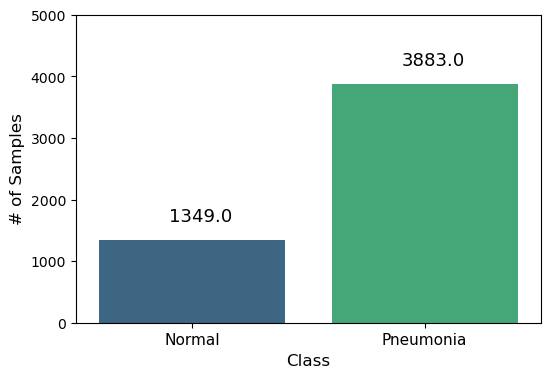

In [11]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette='viridis')

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

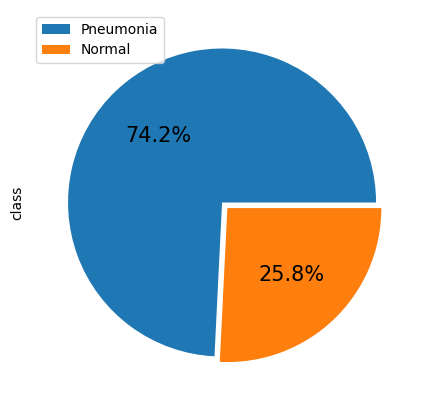

In [12]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

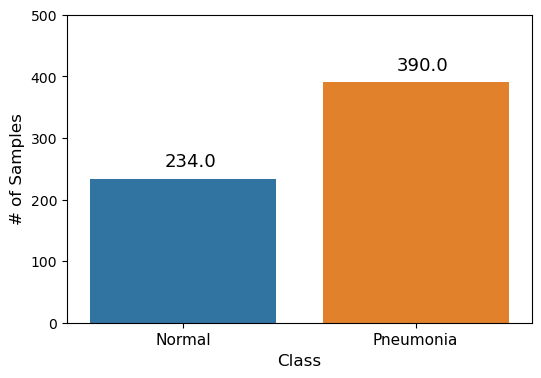

In [13]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test)

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

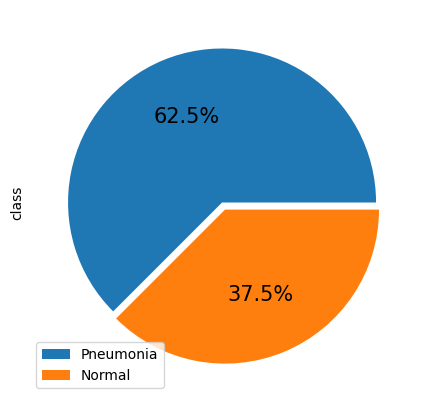

In [14]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

The distributions from these datasets are a little different from each other. Both are slightly imbalanced, having more samples from the positive class (Pneumonia), with the training set being a little more imbalanced.

Before we move on to the next section, we will take a look at a few examples from each dataset.

**Data Visualisation**

Train Set - Normal


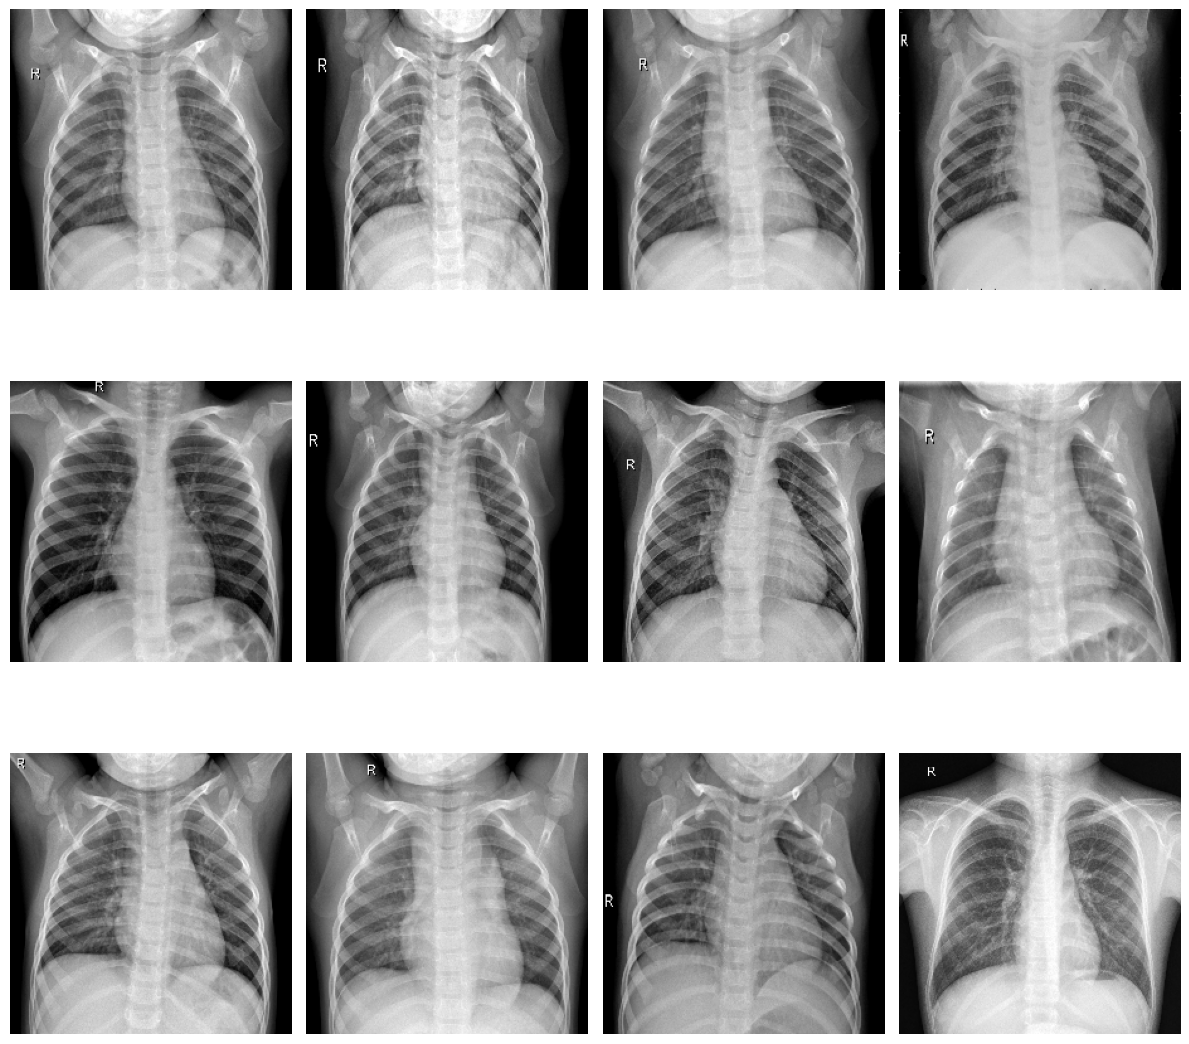

In [15]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


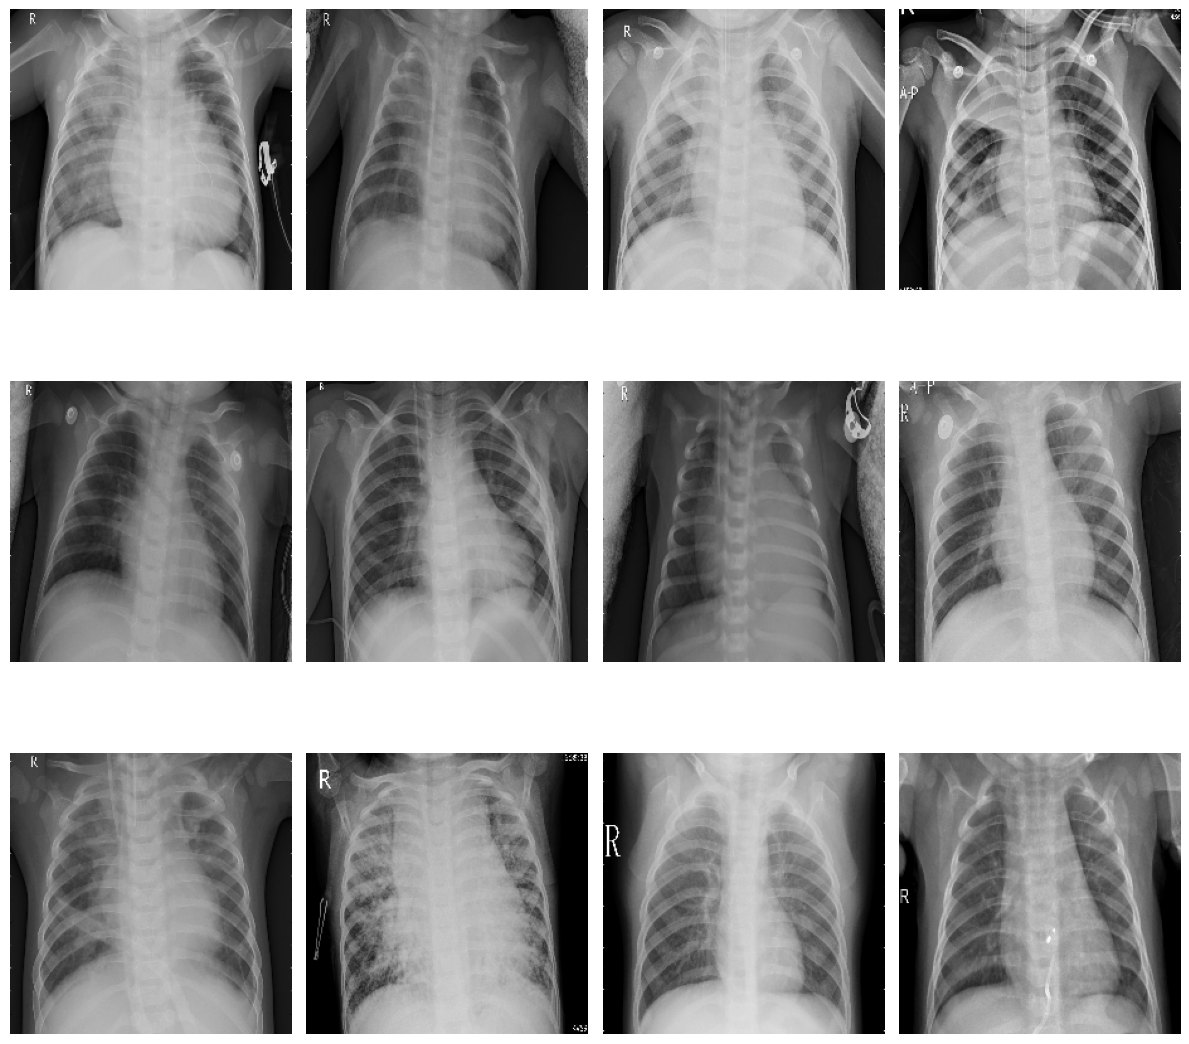

In [16]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


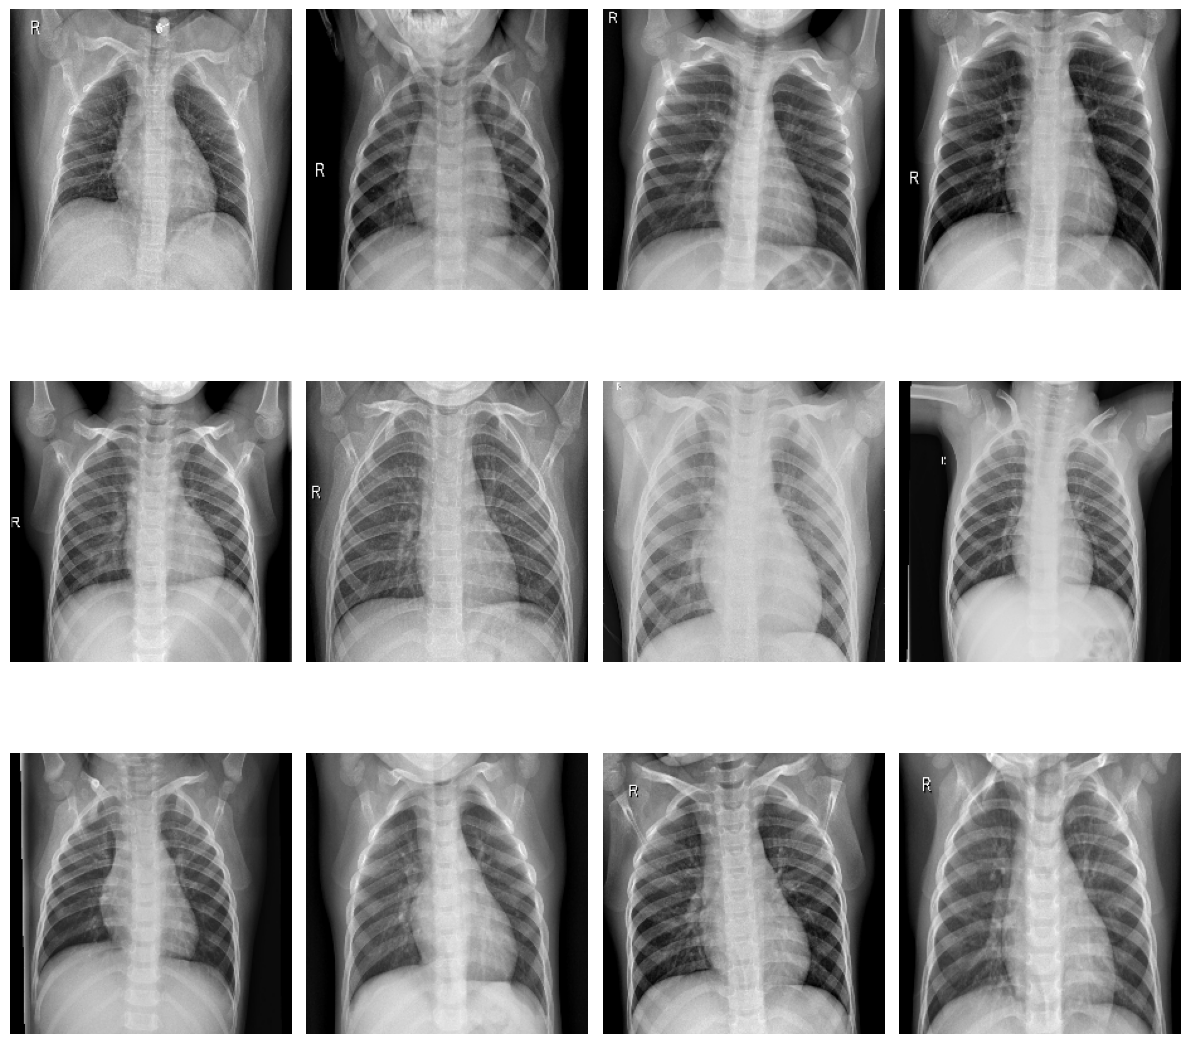

In [17]:
print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


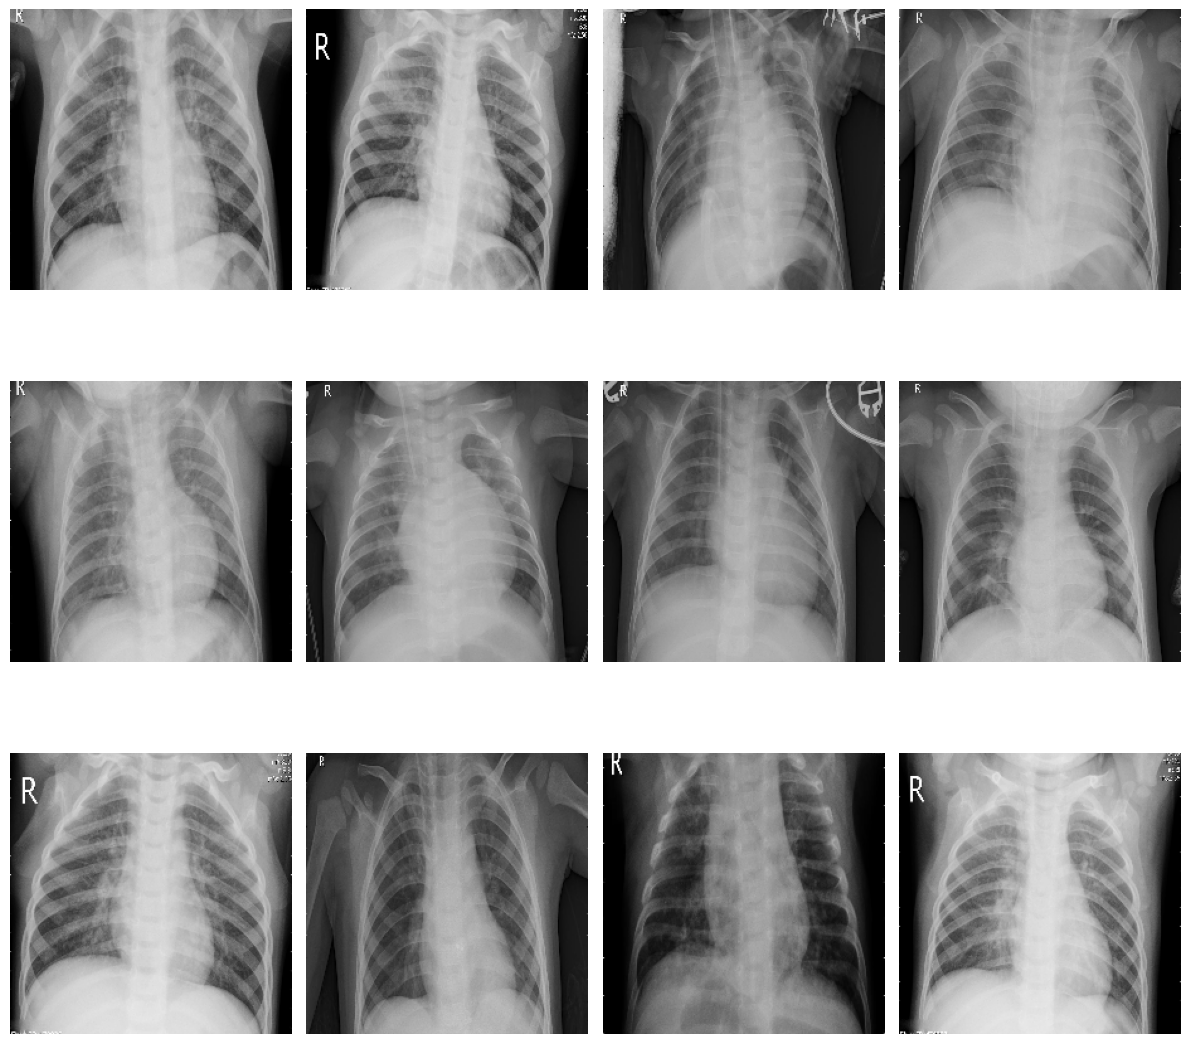

In [18]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

# <a id="4">Preparing the Data</a> 

First, we need to create a validation set. To do that, we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [19]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [20]:
train_df

class  \
3566  Pneumonia   
2866  Pneumonia   
2681  Pneumonia   
1199     Normal   
4619  Pneumonia   
...         ...   
3476  Pneumonia   
678      Normal   
1560  Pneumonia   
2769  Pneumonia   
4881  Pneumonia   

                                                                                         image  
3566  ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-9044474-0002.jpeg  
2866     ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/VIRUS-6149071-0005.jpeg  
2681  ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-3309082-0001.jpeg  
1199       ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-6433176-0001.jpeg  
4619  ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-6991447-0001.jpeg  
...                                                                                        ...  
3476    ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-86966-0001.jpeg  
678        ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-9394101-0001.jpeg  
1560  ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-1632190-0001.jpeg  
2769      ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/VIRUS-696130-0003.jpeg  
4881      ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/VIRUS-666371-0002.jpeg  

[4185 rows x 2 columns]

In [21]:
val_df

class  \
2945  Pneumonia   
4878  Pneumonia   
3177  Pneumonia   
972      Normal   
3059  Pneumonia   
...         ...   
253      Normal   
4315  Pneumonia   
687      Normal   
3417  Pneumonia   
3745  Pneumonia   

                                                                                         image  
2945      ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/VIRUS-463487-0010.jpeg  
4878     ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/VIRUS-6686792-0002.jpeg  
3177  ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-4617189-0004.jpeg  
972        ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-3514363-0003.jpeg  
3059  ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-4011726-0001.jpeg  
...                                                                                        ...  
253         ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-431263-0001.jpeg  
4315  ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-2648560-0002.jpeg  
687         ../input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-471048-0001.jpeg  
3417   ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-140838-0004.jpeg  
3745  ../input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-8313249-0005.jpeg  

[1047 rows x 2 columns]

Now, we’re going to load the images from the folders and prepare them to feed our models. 

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [22]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  rotation_range = 70,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)




Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


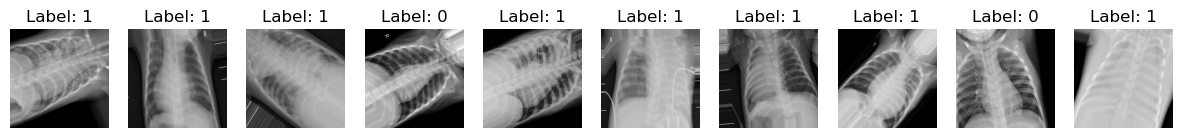

In [23]:
def visualize_augmentations(data_gen, num_images=10):
    images, labels = next(data_gen)
    
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {int(labels[i])}')
        plt.axis('off')
    plt.show()

visualize_augmentations(ds_train)


Now, we are ready for the next stage: creating and training the image classification models.

# <a id="5">Custom CNN</a>

In [24]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

Let’s define our first model ‘from scratch’ and see how it performs.

**Model Architecture**

In [25]:

#This is a model with 3 convolutional blocks
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model
'''
def get_model():
#This is a model with 5 convolutional blocks
    # Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)
    
    # Block Four
    x = layers.Conv2D(filters=128, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)
    
    # Block Five
    x = layers.Conv2D(filters=256, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model
'''

"\ndef get_model():\n#This is a model with 5 convolutional blocks\n    # Input shape = [width, height, color channels]\n    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))\n    \n    # Block One\n    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)\n    x = layers.BatchNormalization()(x)\n    x = layers.Activation('relu')(x)\n    x = layers.MaxPool2D()(x)\n    x = layers.Dropout(0.2)(x)\n\n    # Block Two\n    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)\n    x = layers.BatchNormalization()(x)\n    x = layers.Activation('relu')(x)\n    x = layers.MaxPool2D()(x)\n    x = layers.Dropout(0.2)(x)\n    \n    # Block Three\n    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)\n    x = layers.BatchNormalization()(x)\n    x = layers.Activation('relu')(x)\n    x = layers.MaxPool2D()(x)\n    x = layers.Dropout(0.4)(x)\n    \n    # Block Four\n    x = layers.Conv2D(filters=128, kernel_size=3, padding='valid')(x)\n    x = layers.BatchNo

In [26]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

**Training**

In [27]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 73s 556ms/step - loss: 0.5253 - binary_accuracy: 0.7608 - val_loss: 1.5546 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 2/50
130/130 [==============================] - 73s 560ms/step - loss: 0.3720 - binary_accuracy: 0.8244 - val_loss: 2.7961 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 3/50
131/130 [==============================] - ETA: 0s - loss: 0.3248 - binary_accuracy: 0.8478
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 74s 564ms/step - loss: 0.3248 - binary_accuracy: 0.8478 - val_loss: 2.8727 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 4/50
130/130 [==============================] - 75s 574ms/step - loss: 0.2923 - binary_accuracy: 0.8738 - val_loss: 1.9306 - val_binary_accuracy: 0.7421 - lr: 6.0000e-06
Epoch 5/50
130/130 [==============================] - 73s 559ms/step - loss: 0.2933 - binary_accuracy: 0.8710 - val_loss: 0.461

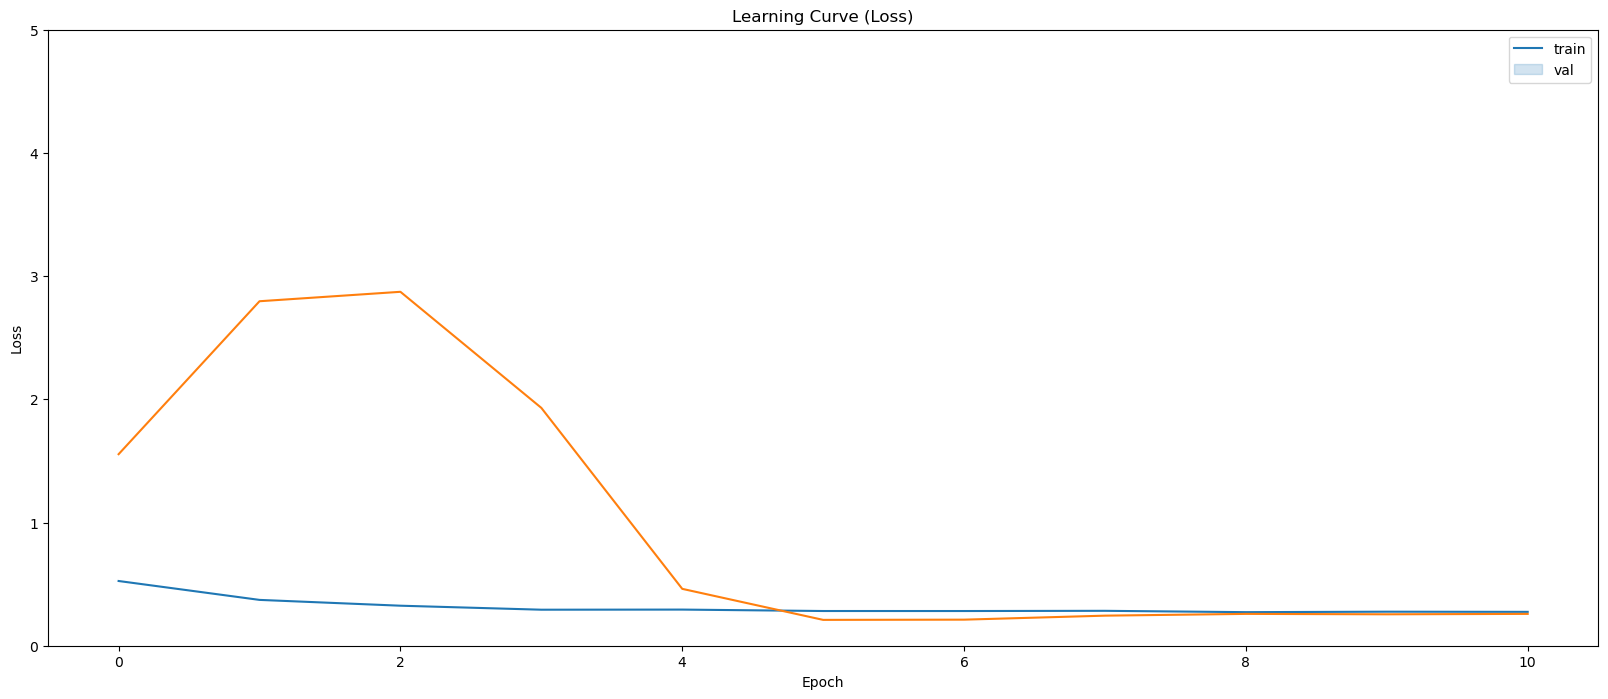

In [28]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 5)
ax.legend(['train', 'val'], loc='best')
plt.show()

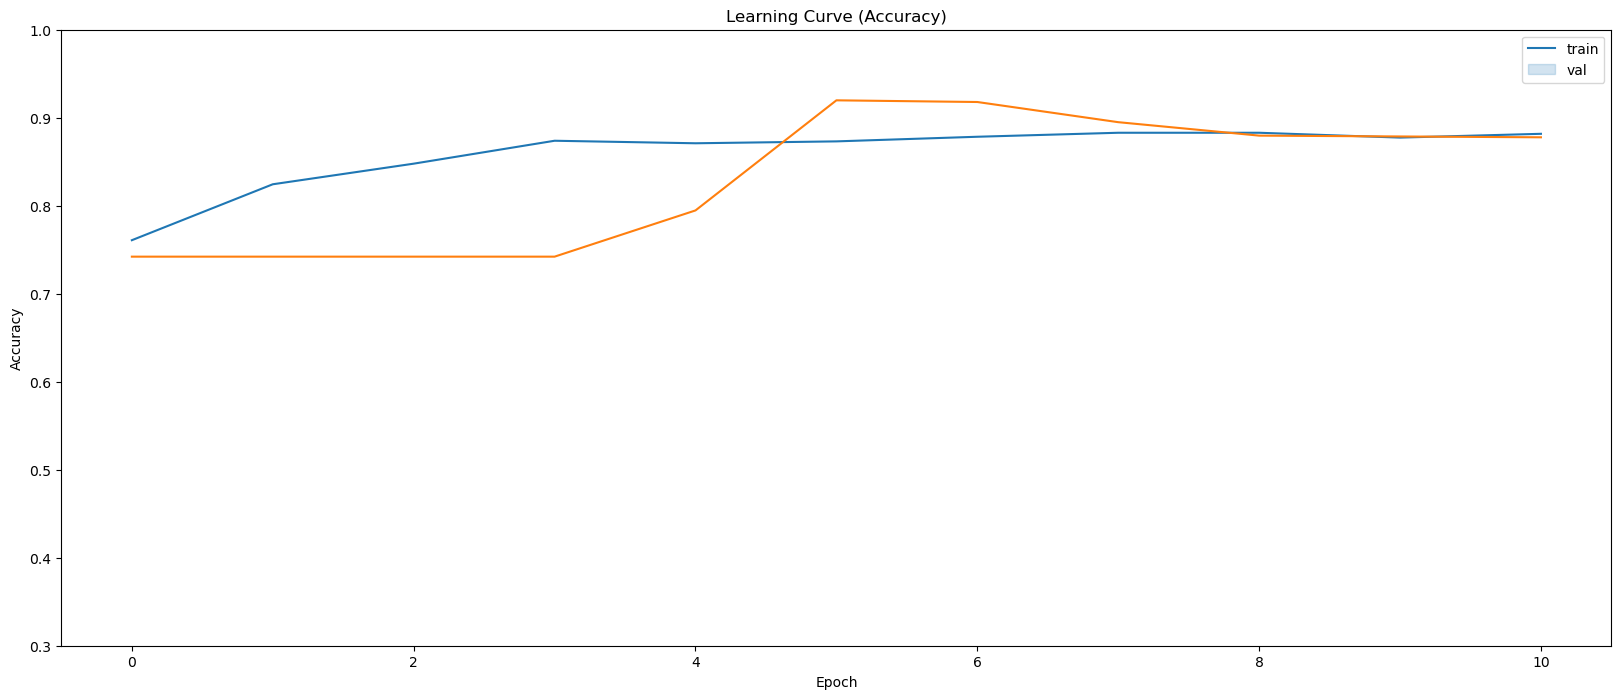

In [29]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.3, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

**Classification Report**

# <a id="6">Performance Metrics</a>

In [30]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.20978569984436035
Val accuracy: 0.9197707772254944


In [31]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.42947128415107727
Test accuracy: 0.8429487347602844


The recall was close to 100%. Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.

**Classification Report**

In [32]:
from sklearn.metrics import classification_report

# Generating predictions on the test set
y_pred = model.predict(ds_test).flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary predictions

# Generating classification report
print(classification_report(ds_test.classes, y_pred))


624/624 [==============================] - 8s 12ms/step
              precision    recall  f1-score   support

           0       0.94      0.62      0.75       234
           1       0.81      0.97      0.89       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624



624/624 [==============================] - 8s 12ms/step


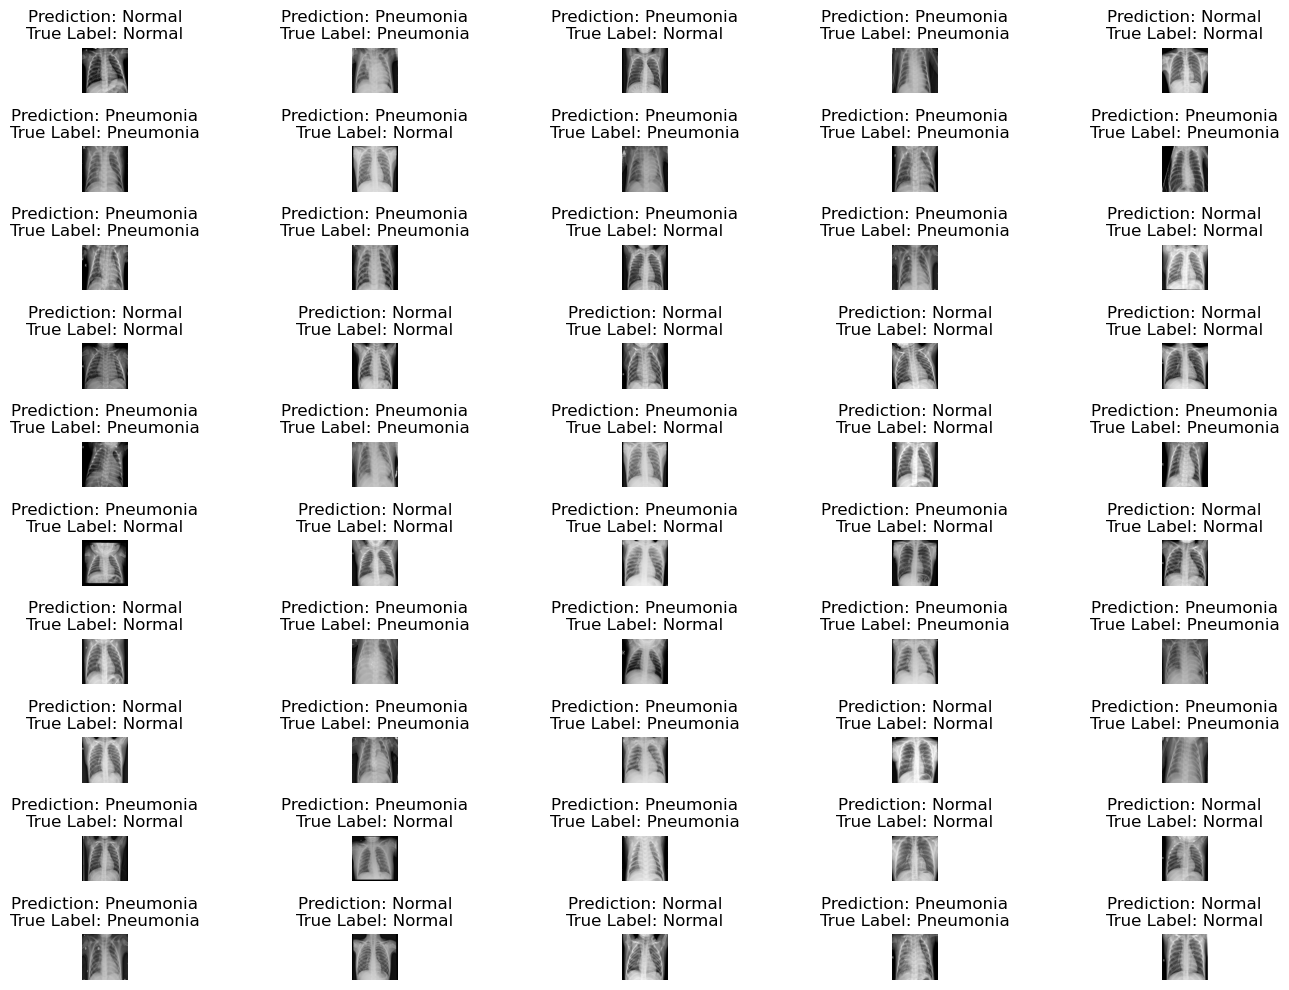

In [33]:
# Generating predictions on the test set
y_pred = model.predict(ds_test).flatten()
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary predictions

# Get true labels from ds_test
true_labels = ds_test.classes

# Get class names
class_names = ds_test.class_indices
class_names = {v: k for k, v in class_names.items()}

# Visualize predictions
L = 10  # Number of rows in the grid
W = 5 # Number of columns in the grid

fig, axes = plt.subplots(L, W, figsize=(15, 10))
axes = axes.ravel()

for i in range(L * W):
    idx = np.random.randint(0, len(ds_test))
    img_path = ds_test.filepaths[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB format
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    axes[i].imshow(img)
    axes[i].set_title(f'Prediction: {class_names[y_pred_binary[idx]]}\nTrue Label: {class_names[true_labels[idx]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [79]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_pred_prob = model.predict(ds_test)
# Get the predicted labels
y_pred = (y_pred_prob > 0.5).astype(np.int)

# Compute AUROC
fpr, tpr, _ = roc_curve(true_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc:.5f}")

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, y_pred).ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Specificity: {specificity:.5f}")
print(f"Sensitivity: {sensitivity:.5f}")

624/624 [==============================] - 7s 11ms/step
AUROC: 0.93892
Specificity: 0.62393
Sensitivity: 0.97436


# **POST TRAINING QUANTISATION**

In [80]:
import tensorflow as tf

# Convert the model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Perform post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/k4/gczjyz2n3wqg55mfxfkq7mkr0000gn/T/tmpj5goo54i/assets


INFO:tensorflow:Assets written to: /var/folders/k4/gczjyz2n3wqg55mfxfkq7mkr0000gn/T/tmpj5goo54i/assets
2024-07-07 19:57:11.380565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-07-07 19:57:11.380580: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-07-07 19:57:11.380683: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/k4/gczjyz2n3wqg55mfxfkq7mkr0000gn/T/tmpj5goo54i
2024-07-07 19:57:11.382165: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-07-07 19:57:11.382170: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/k4/gczjyz2n3wqg55mfxfkq7mkr0000gn/T/tmpj5goo54i
2024-07-07 19:57:11.386278: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-07-07 19:57:11.450156: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

In [81]:
import tensorflow as tf
import numpy as np

# Load the TFLite model from the byte string and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [82]:
import numpy as np
from tqdm import tqdm

y_true = []
y_pred = []

for _, row in tqdm(df_test.iterrows(), total=len(df_test), unit="sample"):
    image_path = row['image']
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    interpreter.set_tensor(input_index, image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)
    y_pred.append(output[0][0])
    y_true.append(row['class'])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

100%|████████████████████████████████████| 624/624 [00:04<00:00, 140.97sample/s]


In [83]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label='Pneumonia')
auroc = auc(fpr, tpr)

print(f"AUROC: {auroc:.5f}")

AUROC: 0.93891


In [84]:
# Convert string labels to numerical values
y_true_binary = (y_true == 'Pneumonia').astype(int)

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred.round()).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.5f}")
print(f"Specificity: {specificity:.5f}")

Sensitivity: 0.97436
Specificity: 0.62393


# **QUANTIZATION AWARE TRAINING**

In [85]:
import tensorflow_model_optimization as tfmot
qat_model = tfmot.quantization.keras.quantize_model(model)

In [88]:
qat_model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

In [89]:
qat_model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 78s 593ms/step - loss: 0.3013 - binary_accuracy: 0.8595 - val_loss: 0.1996 - val_binary_accuracy: 0.9245 - lr: 3.0000e-05
Epoch 2/50
130/130 [==============================] - 80s 608ms/step - loss: 0.2749 - binary_accuracy: 0.8829 - val_loss: 0.1900 - val_binary_accuracy: 0.9360 - lr: 3.0000e-05
Epoch 3/50
130/130 [==============================] - 84s 646ms/step - loss: 0.2732 - binary_accuracy: 0.8884 - val_loss: 0.2035 - val_binary_accuracy: 0.9160 - lr: 3.0000e-05
Epoch 4/50
131/130 [==============================] - ETA: 0s - loss: 0.2460 - binary_accuracy: 0.8953
Epoch 4: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 83s 638ms/step - loss: 0.2460 - binary_accuracy: 0.8953 - val_loss: 0.2451 - val_binary_accuracy: 0.8797 - lr: 3.0000e-05
Epoch 5/50
130/130 [==============================] - 83s 635ms/step - loss: 0.2401 - binary_accuracy: 0.9027 - val_loss: 0.290

In [95]:
y_pred_prob = qat_model.predict(ds_test)
# Get the predicted labels
y_pred = (y_pred_prob > 0.5).astype(np.int)

# Compute AUROC
fpr, tpr, _ = roc_curve(true_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc:.5f}")

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, y_pred).ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Specificity: {specificity:.5f}")
print(f"Sensitivity: {sensitivity:.5f}")

624/624 [==============================] - 9s 15ms/step
AUROC: 0.93481
Specificity: 0.67949
Sensitivity: 0.96923


# **MIXED PRECISION TRAINING**

In [91]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [93]:
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

In [94]:
model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 79s 602ms/step - loss: 0.2858 - binary_accuracy: 0.8757 - val_loss: 0.1979 - val_binary_accuracy: 0.9245 - lr: 3.0000e-05
Epoch 2/50
130/130 [==============================] - 81s 619ms/step - loss: 0.2695 - binary_accuracy: 0.8934 - val_loss: 0.2426 - val_binary_accuracy: 0.8921 - lr: 3.0000e-05
Epoch 3/50
131/130 [==============================] - ETA: 0s - loss: 0.2635 - binary_accuracy: 0.8925
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 80s 610ms/step - loss: 0.2635 - binary_accuracy: 0.8925 - val_loss: 0.2298 - val_binary_accuracy: 0.8959 - lr: 3.0000e-05
Epoch 4/50
130/130 [==============================] - 79s 606ms/step - loss: 0.2444 - binary_accuracy: 0.9001 - val_loss: 0.2283 - val_binary_accuracy: 0.8930 - lr: 6.0000e-06
Epoch 5/50
131/130 [==============================] - ETA: 0s - loss: 0.2416 - binary_accuracy: 0.9035
Epoch 5: ReduceLROnPlate

In [96]:
y_pred_prob = model.predict(ds_test)
# Get the predicted labels
y_pred = (y_pred_prob > 0.5).astype(np.int)

# Compute AUROC
fpr, tpr, _ = roc_curve(true_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc:.5f}")

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, y_pred).ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Specificity: {specificity:.5f}")
print(f"Sensitivity: {sensitivity:.5f}")

624/624 [==============================] - 8s 12ms/step
AUROC: 0.93937
Specificity: 0.71368
Sensitivity: 0.95128
